# Hypothesis Testing

## Libraries

In [447]:
import os, itertools, csv, ast
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from tqdm import tqdm

In [448]:
def corrMat(covars, responses, df):
    corrMat = pd.DataFrame(columns=covars, index=responses)
    for c2 in covars:
        for c1 in responses:
            corrMat.at[c1, c2] = df[c2].corr(df[c1])
    return corrMat

## Reading In Initial Files

We only need to read in in-migration file as we are not as concerned about directionality.

In [449]:
with open("Helge_code/Sudan_states_inmigration_2023-10-21.csv","r") as f:
    non_agg = pd.read_csv(f)
non_agg["date_later"] = pd.to_datetime(non_agg["date_later"])
non_agg.head()

,to,date_later,val,sentiment_pos_comboLex_mean,sentiment_neg_comboLex_mean,sentiment_neu_comboLex_mean,sentiment_SVM_mean,sentiment_pos_multiBERT_mean,sentiment_neg_multiBERT_mean,anger_NaiveBayes_mean,...,sadness_Lex_max,disgust_Lex_max,joy_Lex_max,anger-disgust_Lex_max,anger_GloVe_max,fear_GloVe_max,sadness_GloVe_max,disgust_GloVe_max,joy_GloVe_max,anger-disgust_GloVe_max
0,Aj Jazirah,2023-04-27,8795.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Aj Jazirah,2023-05-05,41085.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Aj Jazirah,2023-05-12,10245.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Aj Jazirah,2023-05-21,4109.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Aj Jazirah,2023-05-29,5050.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Pick One Model for Sentiment and Emotion

In [450]:
senti = ["comboLex","SVM","multiBERT"][-1]
emo = ["Lex","NaiveBayes","GloVe"][-1]

cols = ["to","date_later","val"]
for col in non_agg.columns:
    if senti in col or emo in col:
        cols.append(col)
non_agg = non_agg[cols]
non_agg.columns

Index(['to', 'date_later', 'val', 'sentiment_pos_multiBERT_mean',
       'sentiment_neg_multiBERT_mean', 'anger_GloVe_mean', 'fear_GloVe_mean',
       'sadness_GloVe_mean', 'disgust_GloVe_mean', 'joy_GloVe_mean',
       'anger-disgust_GloVe_mean', 'sentiment_pos_multiBERT_sum',
       'sentiment_neg_multiBERT_sum', 'anger_GloVe_sum', 'fear_GloVe_sum',
       'sadness_GloVe_sum', 'disgust_GloVe_sum', 'joy_GloVe_sum',
       'anger-disgust_GloVe_sum', 'sentiment_pos_multiBERT_max',
       'sentiment_neg_multiBERT_max', 'anger_GloVe_max', 'fear_GloVe_max',
       'sadness_GloVe_max', 'disgust_GloVe_max', 'joy_GloVe_max',
       'anger-disgust_GloVe_max'],
      dtype='object')

## Aggregate Up To Sudan Level

Each data point will represent the number of people *moving* within sudan on each day. Aggregation columns for indicators (eg mean_anger) will be summed, meaned, or maxed accordingly.

In [451]:
agg = non_agg.drop("to", axis  =1)

agg_methods = {}
for column in list(agg.columns)[1:]:
    if column == "val" or "sum" in column:
        agg_methods[column]="sum"
    elif "mean" in column:
        agg_methods[column]="mean"
    elif "max" in column:
        agg_methods[column]="max"

agg = agg.groupby("date_later").agg(agg_methods).reset_index().rename(columns={"val":"IDP"})
agg.head()

,date_later,IDP,sentiment_pos_multiBERT_mean,sentiment_neg_multiBERT_mean,anger_GloVe_mean,fear_GloVe_mean,sadness_GloVe_mean,disgust_GloVe_mean,joy_GloVe_mean,anger-disgust_GloVe_mean,...,joy_GloVe_sum,anger-disgust_GloVe_sum,sentiment_pos_multiBERT_max,sentiment_neg_multiBERT_max,anger_GloVe_max,fear_GloVe_max,sadness_GloVe_max,disgust_GloVe_max,joy_GloVe_max,anger-disgust_GloVe_max
0,2023-04-27,334053.0,0.073993,0.208247,0.080439,0.001286,0.065803,0.014563,0.116062,0.092868,...,1461.0,15451.0,0.836597,0.945177,1.0,1.0,1.0,1.0,1.0,1.0
1,2023-05-05,436243.0,0.074319,0.212659,0.070817,0.000312,0.030667,0.013773,0.004589,0.076541,...,162.0,1246.0,0.827602,0.936906,1.0,1.0,1.0,1.0,1.0,1.0
2,2023-05-12,104155.0,0.082951,0.199398,0.095056,0.057250,0.058543,0.035491,0.067667,0.098177,...,42.0,907.0,0.748459,0.939466,1.0,1.0,1.0,1.0,1.0,1.0
3,2023-05-21,227036.0,0.069563,0.159520,0.124385,0.000069,0.001245,0.013956,0.057493,0.126045,...,29.0,566.0,0.704562,0.939115,1.0,1.0,1.0,1.0,1.0,1.0
4,2023-05-29,166956.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


## Time Series For Aggregations

In [452]:
def plot(df, agg, colors = []):
    if not colors:
        colors = ['#8AFF8A','#FF8A8A','#8A0000','#B57EDC',
                '#0000FF','#006400','#FFD700','#8B4513']
    df_plt = df[list(df.columns[:2]) + [c for c in df.columns if agg in c]]
    
    fig, ax1 = plt.subplots()
    for i, col in enumerate([c for c in df_plt.columns if agg in c]):
        ax1.plot(df_plt["date_later"], df_plt[col], label=col, color = colors[i])
    ax1.set_xlabel("Date Later")
    ax1.set_ylabel(agg) 

    ax2 = ax1.twinx()
    ax2.plot(df_plt["date_later"], df_plt["IDP"], label="IDP", color="r", linestyle = "--")
    ax2.set_ylabel("IDP")

    ax1.tick_params(axis="x", labelrotation=90)
    ax2.tick_params(axis="x", labelrotation=90)

    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines + lines2, labels + labels2,fontsize="small",loc='upper center',ncol=3,bbox_to_anchor=(0.5, -0.3))
    


#### Mean

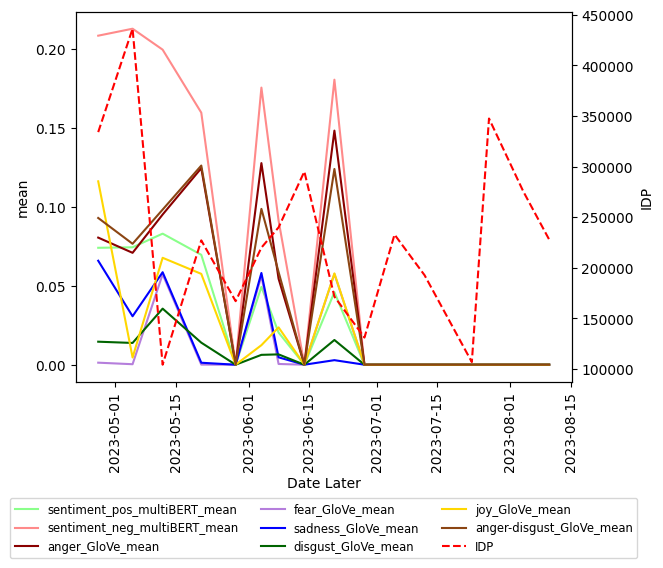

In [453]:
plot(agg, "mean")

#### Sum

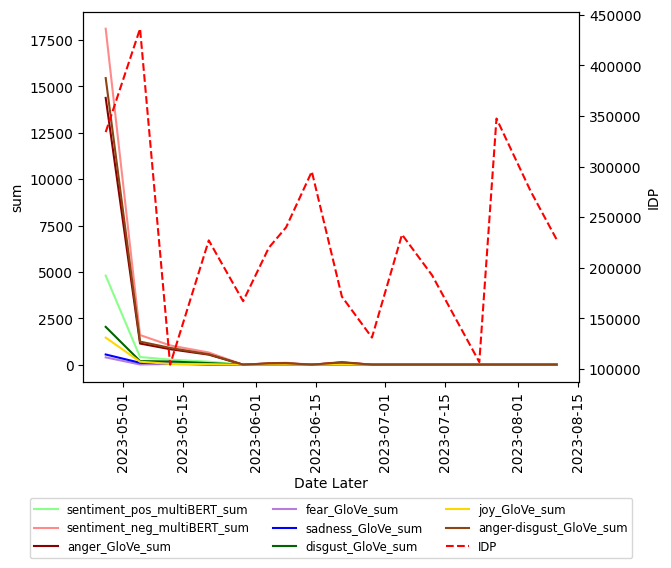

In [454]:
plot(agg, "sum")

#### Max

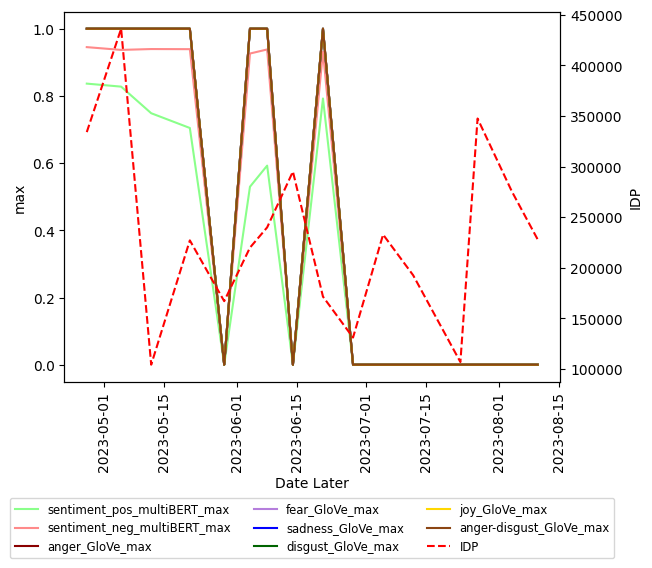

In [455]:
plot(agg, "max")

## Time Shifting

Function to shift time 

In [456]:
def time_shift(df, td, date_col = "date_later", val_cols = ["IDP"]):
    dates = list(df[date_col].unique())
    def shift(date):
        if dates.index(date)+td < 0 or dates.index(date)+td >= len(dates):
            return "08/11/2024"
        else:
            return dates[dates.index(date)+td]

    left = df[[date_col] + val_cols].copy()
    right = df[[elem for elem in df.columns if elem not in val_cols]].copy()
    right[date_col] = pd.to_datetime(right[date_col].apply(shift))
    return pd.merge(left, right, on = [date_col], how = "inner")

## Correlation with Time Shift

In [457]:
def time_shift_plot(agg, max_td, agg_method):
    sub_cols = [c for c in agg.columns if agg_method in c]

    max_td = min(len(agg)-2, max_td)
    td_df = agg[["date_later","IDP"]+sub_cols]

    td_data = {c:[] for c in sub_cols}
    td_data["time shift"] = []
    td_data["datapoints"] = []

    for i in range(-1*max_td, max_td+1):
        td_data["time shift"].append(i)

        td = time_shift(td_df, i)
        td_data["datapoints"].append(len(td))

        for c in sub_cols:
            td_data[c].append(td["IDP"].corr(td[c]))

    td_data = pd.DataFrame(td_data).dropna().rename(columns = {c:" ".join(c.split("_")[:-2]) for c in sub_cols})

    fig, ax = plt.subplots()
    colors = ['#8AFF8A','#FF8A8A','#8A0000','#B57EDC',
                '#0000FF','#006400','#FFD700','#8B4513']
    for i,col in enumerate(td_data.columns):
        if col not in ["time shift","datapoints"]:
            l_style = "--" if "sentiment" in col else "-"
            ax.plot(td_data["time shift"], td_data[col], label=col, color = colors[i], linewidth = 2, linestyle = l_style)

    ax.set_ylim(-1,1)
    ax.legend(bbox_to_anchor=(1, 1))
    ax.set_xlabel("Time Shift (pos. shift -> indicator afterward)")
    ax.set_ylabel("Correlation Coefficient")
    ax.set_title(f"Correlation Coefficient Between IDP and {agg_method.upper()} as a Function of Time Shift")
    td_data["avg corr ^2"] = (td_data[[c for c in td_data.columns if c not in ["time shift","datapoints"]]] ** 2).mean(axis=1)
    td_data = td_data[["time shift","datapoints","avg corr ^2"] + [c for c in td_data.columns if c not in ["time shift","datapoints","avg corr ^2"]]]
    return td_data.sort_values("avg corr ^2", ascending=False)

In [458]:
def time_shift_heatmap(agg, td, agg_method, covar = [], response = ["IDP"]):
    sub_cols = [c for c in agg.columns if agg_method in c]
    td_df = agg[["date_later","IDP"]+sub_cols]

    td_df = time_shift(td_df, td).drop(columns = ["date_later"]).rename(columns = {c:" ".join(c.split("_")[:-2]) for c in sub_cols})

    covar = covar if covar else [c for c in td_df if c not in response]
    cm = corrMat(covar, response, td_df)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm.astype(float), annot=False, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title(f"Correlation Heatmap for {agg_method.upper()}")
    plt.show()
        
    return

### Correlations Between IDP and indicators

#### Sum

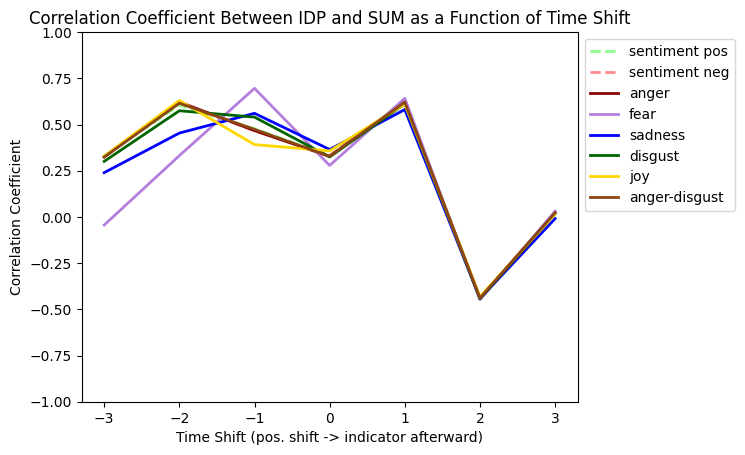

In [459]:
sum_td_df = time_shift_plot(agg,3,"sum")

In [460]:
sum_td_df

,time shift,datapoints,avg corr ^2,sentiment pos,sentiment neg,anger,fear,sadness,disgust,joy,anger-disgust
4,1,15,0.379684,0.619991,0.618745,0.621758,0.641922,0.580916,0.611713,0.611309,0.621477
1,-2,14,0.319244,0.604647,0.616208,0.622492,0.331582,0.453728,0.574585,0.629830,0.615224
2,-1,15,0.266366,0.476881,0.466258,0.467064,0.695857,0.560609,0.539978,0.391378,0.474044
5,2,14,0.193342,-0.438584,-0.438292,-0.438809,-0.447967,-0.441488,-0.441915,-0.431538,-0.438896
3,0,16,0.109943,0.331954,0.333114,0.327370,0.278376,0.364847,0.324556,0.357356,0.327973
0,-3,13,0.085424,0.329961,0.325769,0.324708,-0.043848,0.239629,0.300540,0.329278,0.323829
6,3,13,0.000450,0.021850,0.020821,0.023307,0.031601,-0.009143,0.017629,0.015260,0.022804


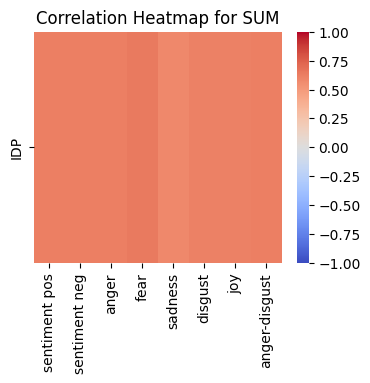

In [461]:
time_shift_heatmap(agg, sum_td_df.at[sum_td_df["avg corr ^2"].idxmax(),"time shift"], "sum")

#### Max

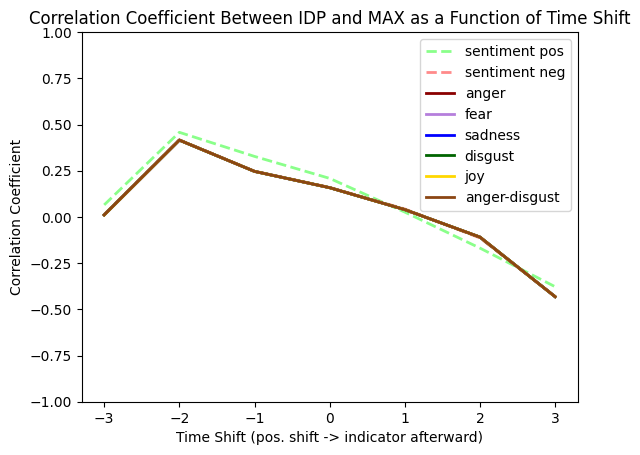

In [462]:
max_td_df = time_shift_plot(agg,3,"max")

In [463]:
max_td_df

,time shift,datapoints,avg corr ^2,sentiment pos,sentiment neg,anger,fear,sadness,disgust,joy,anger-disgust
6,3,13,0.180638,-0.377583,-0.430002,-0.431592,-0.431592,-0.431592,-0.431592,-0.431592,-0.431592
1,-2,14,0.177495,0.457811,0.417477,0.415549,0.415549,0.415549,0.415549,0.415549,0.415549
2,-1,15,0.066607,0.327480,0.247760,0.246383,0.246383,0.246383,0.246383,0.246383,0.246383
3,0,16,0.027398,0.208593,0.159733,0.158197,0.158197,0.158197,0.158197,0.158197,0.158197
5,2,14,0.014116,-0.168612,-0.113853,-0.109192,-0.109192,-0.109192,-0.109192,-0.109192,-0.109192
4,1,15,0.001485,0.026125,0.042913,0.039488,0.039488,0.039488,0.039488,0.039488,0.039488
0,-3,13,0.000638,0.065094,0.013686,0.010663,0.010663,0.010663,0.010663,0.010663,0.010663


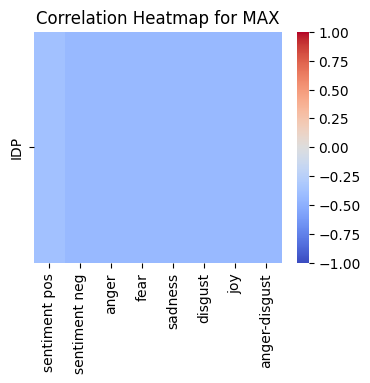

In [464]:
time_shift_heatmap(agg, max_td_df.at[max_td_df["avg corr ^2"].idxmax(),"time shift"], "max")

#### Mean

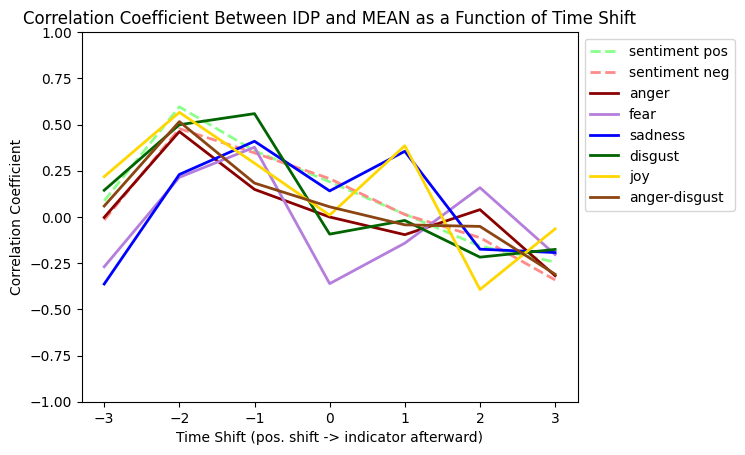

In [465]:
mean_td_df = time_shift_plot(agg,3,"mean")

In [466]:
mean_td_df

,time shift,datapoints,avg corr ^2,sentiment pos,sentiment neg,anger,fear,sadness,disgust,joy,anger-disgust
1,-2,14,0.216251,0.595873,0.477541,0.461784,0.214342,0.229722,0.498879,0.565739,0.515749
2,-1,15,0.126344,0.357976,0.346396,0.148958,0.377246,0.409510,0.558833,0.290903,0.183023
6,3,13,0.060888,-0.244188,-0.341010,-0.318216,-0.203609,-0.192746,-0.175865,-0.064735,-0.310167
4,1,15,0.038331,0.014918,0.012840,-0.096150,-0.141991,0.355250,-0.019143,0.385301,-0.042773
5,2,14,0.037345,-0.157857,-0.112107,0.039385,0.158280,-0.174499,-0.217688,-0.392677,-0.051343
0,-3,13,0.035511,0.087099,-0.016443,-0.002353,-0.269546,-0.363055,0.144246,0.217900,0.058932
3,0,16,0.030112,0.189971,0.207007,-0.000434,-0.361091,0.140791,-0.093068,0.009636,0.054719


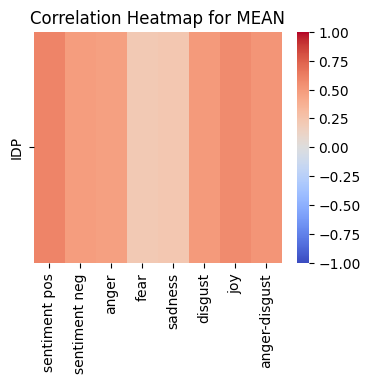

In [467]:
time_shift_heatmap(agg, mean_td_df.at[mean_td_df["avg corr ^2"].idxmax(),"time shift"], "mean")

## 11/14 Plot Ideas

#### Time Series

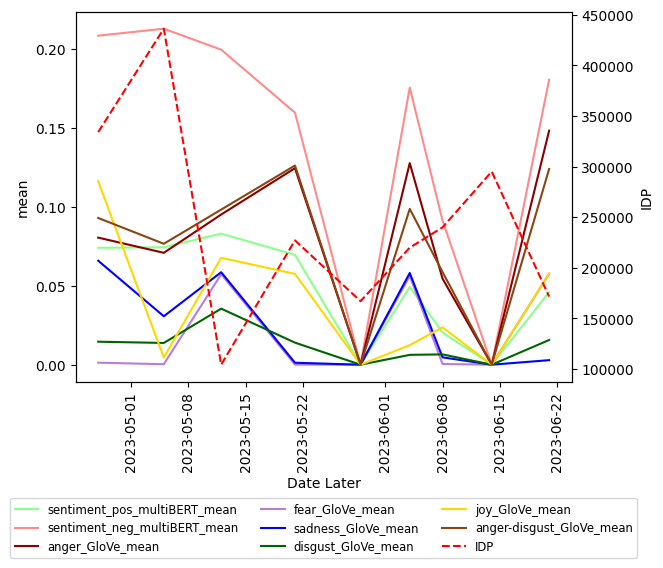

In [468]:
agg = agg[agg["date_later"] <= datetime(2023,6,21)]
plot(agg, "mean")

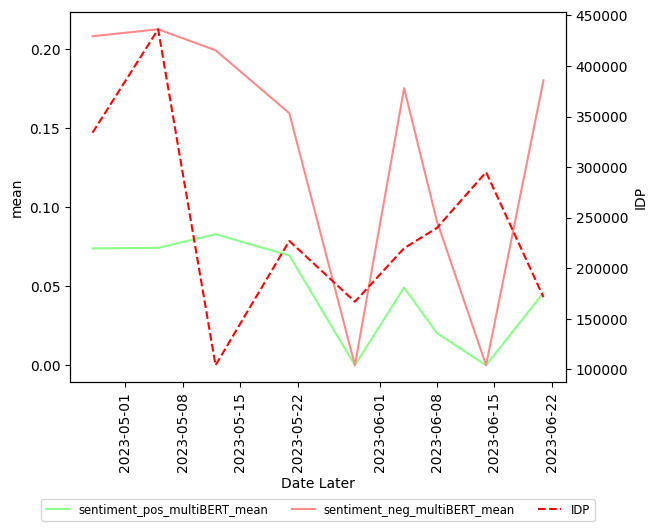

In [469]:
agg_senti = agg[[c for c in agg.columns if c in ["date_later","IDP"] or "sentiment" in c]]
plot(agg_senti, "mean", colors = ['#8AFF8A','#FF8A8A'])

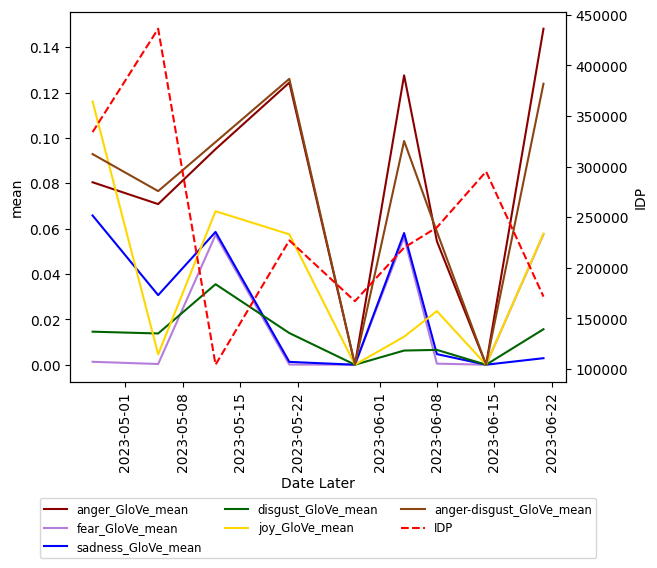

In [470]:
agg_emo = agg[[c for c in agg.columns if "sentiment" not in c]]
plot(agg_emo, "mean", colors = ['#8A0000','#B57EDC','#0000FF','#006400','#FFD700','#8B4513'])

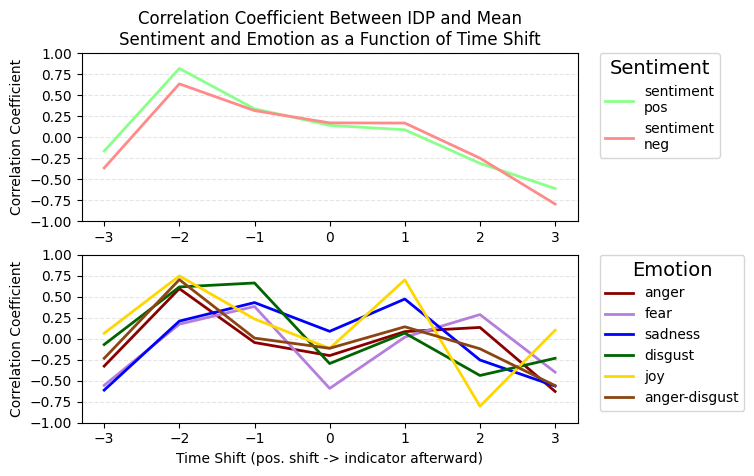

In [519]:
plt_df_emo = agg_emo[[c for c in agg_emo.columns if c in ["date_later","IDP"] or "mean" in c]]
plt_df_senti = agg_senti[[c for c in agg_senti.columns if c in ["date_later","IDP"] or "mean" in c]]

max_td = 3

td_data_emo = {c:[] for c in plt_df_emo.columns if c not in ["IDP","date_later"]}
td_data_senti = {c:[] for c in plt_df_senti.columns if c not in ["IDP","date_later"]}
for d in [td_data_senti, td_data_emo]:
    d["time shift"] = []

for i in range(-1*max_td, max_td+1):
    td_data_emo["time shift"].append(i)
    td_data_senti["time shift"].append(i)

    td_emo = time_shift(plt_df_emo, i)
    for c in td_data_emo:
        if c != "time shift":
            td_data_emo[c].append(td_emo["IDP"].corr(td_emo[c]))

    td_senti = time_shift(plt_df_senti, i)

    for c in td_data_senti:
        if c != "time shift":
            td_data_senti[c].append(td_senti["IDP"].corr(td_senti[c]))
td_data_senti = pd.DataFrame(td_data_senti).dropna().rename(columns = {c:"\n".join(c.split("_")[:-2]) for c in [c for c in td_senti if c != "time shift"]})
td_data_emo = pd.DataFrame(td_data_emo).dropna().rename(columns = {c:" ".join(c.split("_")[:-2]) for c in [c for c in td_emo if c != "time shift"]})

fig, (ax1, ax2) = plt.subplots(2, 1)
colors = ['#8AFF8A','#FF8A8A','#8A0000','#B57EDC','#0000FF','#006400','#FFD700','#8B4513']

for i, col in enumerate(td_data_senti.columns):
    if col != "time shift":
        ax1.plot(td_data_senti["time shift"], td_data_senti[col], label=col, color = colors[i], linewidth = 2)
ax1.set_ylim(-1,1)
ax1.set_ylabel("Correlation Coefficient")
# ax1.text(0.78, 0.91, 'Sentiment', transform=ax1.transAxes, fontsize=14, va='top', ha='left')
ax1.legend(fontsize = 'medium',loc='upper right', bbox_to_anchor=(1.3, 1.04), title = "Sentiment").get_title().set_fontsize(14)

for i, col in enumerate(td_data_emo):
    if col != "time shift":
        ax2.plot(td_data_emo["time shift"], td_data_emo[col], label=col, color = colors[i+len(td_data_senti.columns)-1], linewidth = 2)

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.set_ylim(-1,1)
# ax2.text(0.82, -1.2+0.91, 'Emotion', transform=ax1.transAxes, fontsize=14, va='top', ha='left')
ax2.set_xlabel("Time Shift (pos. shift -> indicator afterward)")
ax2.set_ylabel("Correlation Coefficient")
ax2.legend(fontsize = 'medium',loc='upper right', bbox_to_anchor=(1.35, 1.04), title = "Emotion").get_title().set_fontsize(14)

ax1.set_yticks(np.arange(-1, 1.25, 0.25))
ax1.yaxis.grid(True, linestyle='--', which='major', color='gray', alpha=0.2)

ax2.set_yticks(np.arange(-1, 1.25, 0.25))
ax2.yaxis.grid(True, linestyle='--', which='major', color='gray', alpha=0.2)

ax1.set_title(f"Correlation Coefficient Between IDP and Mean\nSentiment and Emotion as a Function of Time Shift")

plt.show()

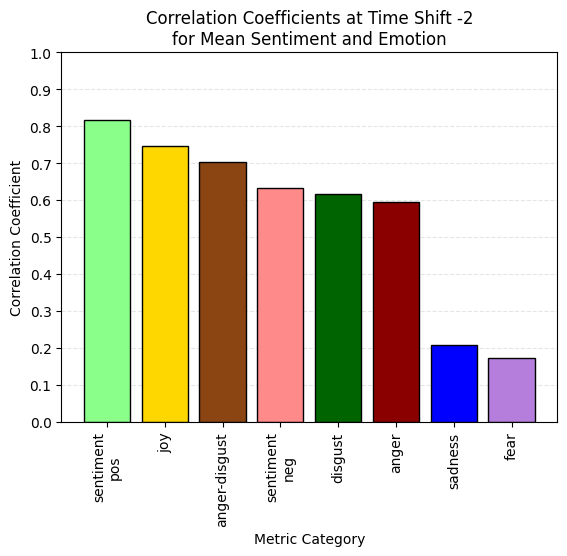

In [511]:
plt2_df = pd.merge(left = td_data_senti, right = td_data_emo, how = "inner", on = "time shift")
plt2_df["msc"] = (plt2_df[[c for c in plt2_df.columns if c != "time shift"]]**2).mean(axis = 1)

colors = ['#8AFF8A','#FF8A8A','#8A0000','#B57EDC','#0000FF','#006400','#FFD700','#8B4513']
color_dict = {}
for i, c in enumerate([c for c in plt2_df.columns if c not in ["time shift","msc"]]):
    color_dict[c] = colors[i]


plt2_data = dict(sorted(dict(plt2_df.drop(columns = ["time shift","msc"]).loc[plt2_df["msc"].idxmax()]).items(), key=lambda item: item[1], reverse = True))

plt.bar(plt2_data.keys(), plt2_data.values(), color=[color_dict[c] for c in plt2_data],edgecolor='black',zorder = 2)

plt.ylim(0,1)
plt.xticks(rotation=90, ha='center')
plt.yticks(np.arange(0, 1.1, 0.1))
plt.grid(axis = "y", linestyle='--', which='major', color='gray', alpha=0.2, zorder = 1)

plt.xlabel('Metric Category')
plt.ylabel('Correlation Coefficient')
plt.title("Correlation Coefficients at Time Shift -2\nfor Mean Sentiment and Emotion")

plt.show()

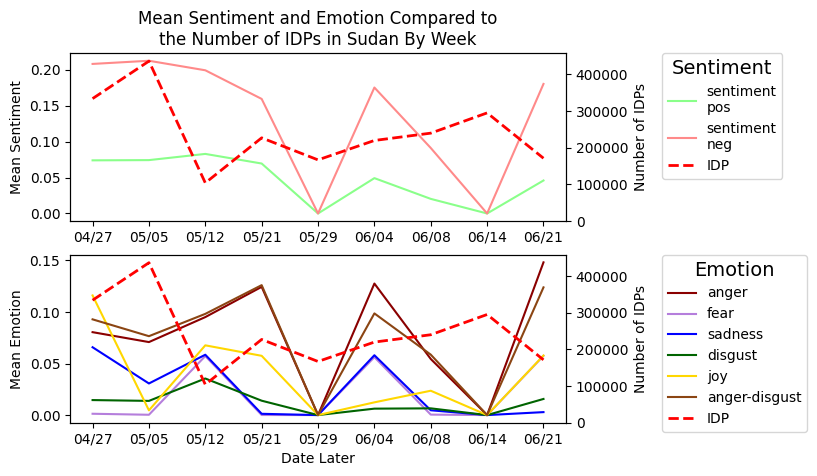

In [588]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=False)
plt3_df_emo = plt_df_emo.rename(columns = {c:" ".join(c.split("_")[:-2]) for c in [c for c in plt_df_emo.columns if c not in ["date_later","IDP"]]})
plt3_df_senti = plt_df_senti.rename(columns = {c:"\n".join(c.split("_")[:-2]) for c in [c for c in plt_df_senti.columns if c not in ["date_later","IDP"]]})
plt3_df_emo["date_later"] = plt3_df_emo["date_later"].dt.strftime('%m/%d')
plt3_df_senti["date_later"] = plt3_df_senti["date_later"].dt.strftime('%m/%d')

colors = ['#8AFF8A','#FF8A8A','#8A0000','#B57EDC','#0000FF','#006400','#FFD700','#8B4513']

senti_lines = []
for i, col in enumerate([c for c in plt3_df_senti.columns if c not in ["IDP","date_later"]]):
    l, = ax1.plot(plt3_df_senti["date_later"], plt3_df_senti[col], color = colors[i])
    senti_lines.append(l)
ax1.set_ylabel("Mean Sentiment")

emo_lines = []
for i, col in enumerate([c for c in plt3_df_emo.columns if c not in ["IDP","date_later"]], start = i+1):
    l, = ax2.plot(plt3_df_emo["date_later"], plt3_df_emo[col], color = colors[i])
    emo_lines.append(l)
ax2.tick_params(axis="x", labelrotation=0)
ax2.set_xlabel("Date Later")
ax2.set_ylabel("Mean Emotion")

ax3 = ax1.twinx()
l, = ax3.plot(plt3_df_senti["date_later"],plt3_df_senti["IDP"],color = "red",linewidth = 2,linestyle="--")
senti_lines.append(l)
ax3.set_ylim(0, 1.05*max(plt3_df_senti["IDP"]))
ax3.set_ylabel("Number of IDPs")

ax4 = ax2.twinx()
l, = ax4.plot(plt3_df_emo["date_later"],plt3_df_emo["IDP"],color = "red",linewidth = 2,linestyle="--")
emo_lines.append(l)
ax4.set_ylim(0, 1.05*max(plt3_df_emo["IDP"]))
ax4.set_ylabel("Number of IDPs")

senti_labs = [c for c in plt3_df_senti.columns if c not in ["IDP","date_later"]] + ["IDP"]
ax1.legend(handles=senti_lines, labels = senti_labs, loc='upper right', bbox_to_anchor=(1.45, 1.04), title = "Sentiment").get_title().set_fontsize(14)

emo_labs = [c for c in plt3_df_emo.columns if c not in ["IDP","date_later"]] + ["IDP"]
ax2.legend(handles=emo_lines, labels = emo_labs, loc='upper right', bbox_to_anchor=(1.5, 1.04), title = "Emotion").get_title().set_fontsize(14)


ax1.set_title("Mean Sentiment and Emotion Compared to\nthe Number of IDPs in Sudan By Week")

plt.show()
